In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
try:
    os.mkdir('figures')
except FileExistsError:
    pass

import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from ccmf import CCMF, CircuitEditor, UniformModel, load_fake_dm9

np.random.seed(69)

/Users/matthias.christenson/anaconda3/envs/ccmf/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
notebook_name = 'linear_no_noise'

In [3]:
editor = CircuitEditor()
circuit = editor.get_circuit()

In [5]:
#circuit.add_egde(name1, name2, sign=)

# Load circuit

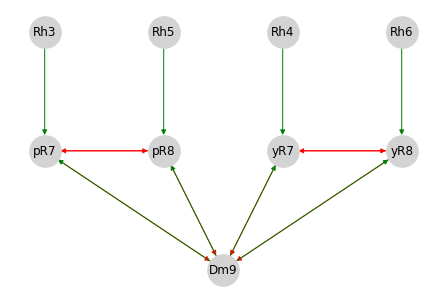

In [3]:
circuit = pickle.load(open('circuits/Dm9.circuit', 'rb'))
circuit.show()

In [6]:
circuit.edges

OutEdgeView([('Rh3', 'pR7'), ('Rh4', 'yR7'), ('Rh5', 'pR8'), ('Rh6', 'yR8'), ('pR7', 'pR8'), ('pR7', 'Dm9'), ('yR7', 'yR8'), ('yR7', 'Dm9'), ('pR8', 'pR7'), ('pR8', 'Dm9'), ('yR8', 'yR7'), ('yR8', 'Dm9'), ('Dm9', 'yR8'), ('Dm9', 'yR7'), ('Dm9', 'pR8'), ('Dm9', 'pR7')])

In [25]:
list(circuit['Rh3'])

['pR7']

In [11]:
circuit.add_weighted_edges_from?

# Load data

In [4]:
W, M, U, X = load_fake_dm9()
X.columns = pd.Index(X.columns.values.astype(int), name=X.columns.name)
X

stimulus,300,327,355,383,411,438,466,494,522,550
cell,,,,,,,,,,
Rh3,0.606531,0.905955,0.993846,0.800737,0.473827,0.205924,0.065729,0.015408,0.002653,0.000335
Rh4,0.135335,0.352322,0.673638,0.945959,0.975611,0.738991,0.411112,0.167973,0.050406,0.011109
Rh5,0.011109,0.050406,0.167973,0.411112,0.738991,0.975611,0.945959,0.673638,0.352322,0.135335
Rh6,0.000335,0.002653,0.015408,0.065729,0.205924,0.473827,0.800737,0.993846,0.905955,0.606531
pR7,0.792459,1.161199,1.194870,0.762329,0.079556,-0.473936,-0.670218,-0.556945,-0.332050,-0.150686
yR7,0.171381,0.454857,0.869636,1.186215,1.103980,0.571343,-0.112891,-0.566997,-0.637469,-0.450452
pR8,-0.398385,-0.549900,-0.456876,-0.016921,0.609885,1.065438,1.090244,0.759515,0.367288,0.119314
yR8,-0.098619,-0.244481,-0.446824,-0.574247,-0.435394,0.041014,0.666359,1.084749,1.073630,0.740392
Dm9,-0.026529,-0.039411,-0.054828,-0.093737,-0.178657,-0.294283,-0.381648,-0.385191,-0.302119,-0.182729


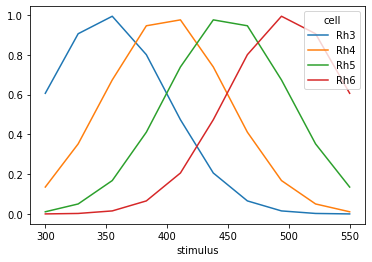

In [20]:
U.T.plot()

# Add noise

In [5]:
Xset = pd.concat([X + np.random.normal(0, .25, X.shape) for _ in range(100)])

In [6]:
Xmean = Xset.groupby('cell').mean().loc[X.index]

In [21]:
Xmean

stimulus,300,327,355,383,411,438,466,494,522,550
cell,,,,,,,,,,
Rh3,0.563361,0.927192,1.004679,0.808405,0.435200,0.191762,0.040919,0.015277,-0.011732,0.041490
Rh4,0.146367,0.302413,0.609997,0.934814,0.952050,0.692571,0.362286,0.127520,0.122181,0.044368
Rh5,0.016949,0.062424,0.200693,0.388368,0.763637,0.936432,0.942417,0.655376,0.407994,0.125531
Rh6,-0.022485,0.017412,-0.024827,0.050433,0.243467,0.497167,0.771252,1.010960,0.910832,0.641741
pR7,0.810918,1.180388,1.169492,0.770635,0.054509,-0.460440,-0.672339,-0.532447,-0.367282,-0.110538
yR7,0.176815,0.447574,0.828219,1.177309,1.095559,0.556542,-0.110041,-0.566178,-0.633564,-0.507150
pR8,-0.403329,-0.537749,-0.462400,-0.021984,0.613282,1.034055,1.069162,0.750402,0.396446,0.117676
yR8,-0.060383,-0.206761,-0.428925,-0.596376,-0.442046,0.038567,0.695584,1.106575,1.062155,0.745531
Dm9,-0.034269,-0.046093,-0.032100,-0.060875,-0.189592,-0.331459,-0.366741,-0.403743,-0.293315,-0.187730


# One sample from the data set

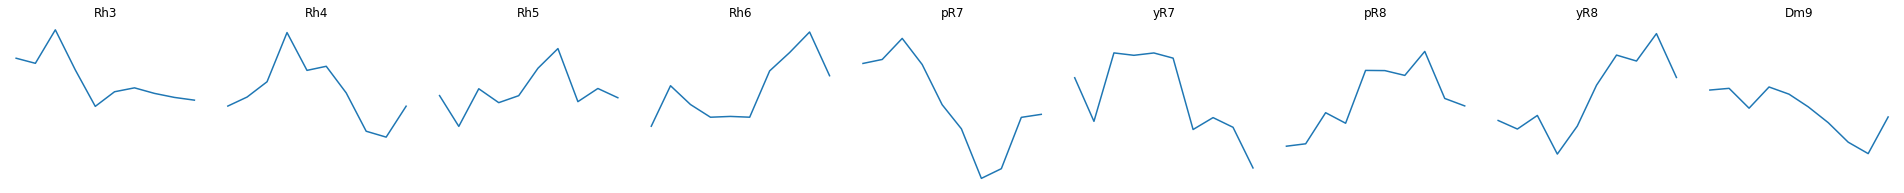

In [7]:
g = sns.FacetGrid(Xset.iloc[:len(X)].stack().to_frame().reset_index(), col='cell')
g.map_dataframe(sns.lineplot, x='stimulus', y=0)
for i, ax in enumerate(g.axes.ravel()):
    ax.axis('off')
    ax.set_title(X.index[i])

# Data mean and SD

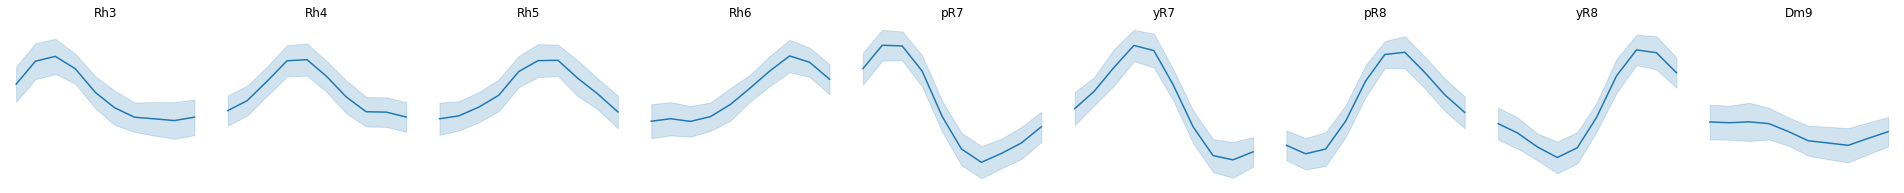

In [8]:
g = sns.FacetGrid(Xset.stack().to_frame().reset_index(), col='cell')
g.map_dataframe(sns.lineplot, x='stimulus', y=0, ci='sd')
for i, ax in enumerate(g.axes.ravel()):
    ax.axis('off')
    ax.set_title(X.index[i])

In [11]:
Xset

stimulus,300,327,355,383,411,438,466,494,522,550
cell,,,,,,,,,,
Rh3,0.835407,0.755070,1.284420,0.650387,0.074455,0.305356,0.367195,0.279483,0.215789,0.172683
Rh4,0.079151,0.221776,0.463621,1.241105,0.643401,0.707892,0.286742,-0.318808,-0.411758,0.077274
Rh5,0.244752,-0.242086,0.352875,0.133074,0.243510,0.677143,0.988116,0.148985,0.357111,0.210882
Rh6,-0.239760,0.400594,0.103492,-0.097258,-0.084576,-0.096933,0.635054,0.925316,1.249897,0.558972
pR7,0.753066,0.815966,1.148702,0.736287,0.100669,-0.280496,-1.063944,-0.910787,-0.099389,-0.051703
...,...,...,...,...,...,...,...,...,...,...
pR7,0.823181,1.243013,1.281313,0.836831,0.148121,-0.912033,-1.300481,-0.810683,-0.248077,-0.105945
yR7,0.363963,0.666861,0.884485,0.901585,1.179202,0.607622,-0.090383,-0.627354,-0.877404,-0.470303
pR8,-0.336736,-0.393730,-0.395667,-0.211780,0.805647,1.496285,1.095740,0.910262,0.171987,0.110656


# Fitting (MAP estimation)

In [12]:
ccmf = CCMF(UniformModel(circuit), sigma_u=1, sigma_x=1, max_iter=2000)
ccmf.fit(Xset)

100%|██████████| 2000/2000 [00:09<00:00, 200.23it/s]


CCMF(guide=None, kernel=None, loss=None, model=None, optimizer=None)

Text(0, 0.5, 'Loss')

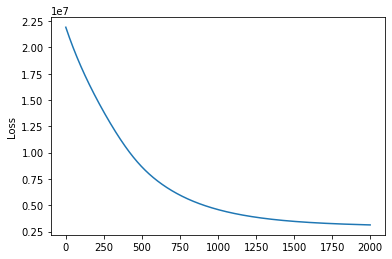

In [13]:
plt.figure()
plt.plot(ccmf.loss_curve)
plt.ylabel('Loss')

# Run MCMC

In [14]:
ccmf.run_mcmc(Xset)

Sample: 100%|██████████| 100/100 [04:19,  2.59s/it, step size=4.88e-04, acc. prob=0.677]


CCMF(guide=None, kernel=None, loss=None, model=None, optimizer=None)

In [15]:
EX = lambda W, M, U: torch.cat([U, UniformModel.EV(W, M, U)])
data = dict(W=W, M=M, U=U, X=Xmean)
for i in ['U', 'X']:
    data[i].columns = pd.Index(data['X'].columns.values.astype(int), name=data['X'].columns.name)
map_ = ccmf.map_estimates.copy()
mean = ccmf.sample_mean.copy()
mean['X'] = EX(mean['W'], mean['M'], mean['U'])
map_['X'] = EX(map_['W'], map_['M'], map_['U'])

In [22]:
map_

{'W': tensor([[7.7356e-01, 8.6120e-13, 5.2138e-13, 3.2918e-13],
         [4.3695e-13, 8.0277e-01, 5.7840e-13, 3.2952e-13],
         [3.7490e-13, 2.8545e-13, 6.0621e-01, 4.5444e-13],
         [4.7296e-13, 3.5979e-13, 6.7741e-13, 5.3106e-01],
         [8.1652e-13, 8.9419e-13, 7.4261e-13, 6.6127e-13]]),
 'M': tensor([[ 7.8618e-13,  6.5997e-13, -6.6432e-01,  3.2523e-13,  6.9325e-01],
         [ 5.3967e-13,  6.5618e-13,  5.8181e-13, -5.5241e-01,  7.5153e-01],
         [-6.8184e-01,  5.0394e-13,  5.0533e-13,  4.9437e-13,  2.7154e-01],
         [ 2.4680e-13, -7.3657e-01,  6.8426e-13,  6.1650e-13,  2.3916e-01],
         [-4.0528e-01, -3.5232e-01, -4.1861e-01, -6.6768e-01,  4.2739e-13]]),
 'U': tensor([[ 0.4069,  0.8442,  0.9389,  0.7023,  0.4703,  0.1709,  0.1412,  0.1087,
           0.0893,  0.0907],
         [ 0.1250,  0.3392,  0.6055,  0.8556,  0.9457,  0.6765,  0.3916,  0.1780,
           0.1052,  0.0311],
         [-0.0937,  0.0974,  0.2573,  0.4332,  0.8087,  0.8502,  0.9024,  0.5722,
  

# Comparing data, MAP, and sample mean
## Feedforward weights

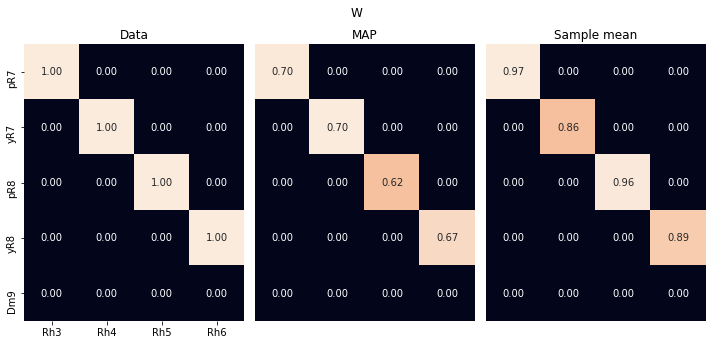

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'W'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Recurrent weights

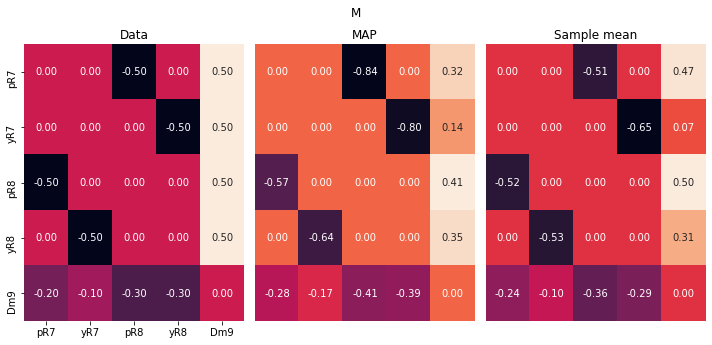

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'M'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Latent inputs

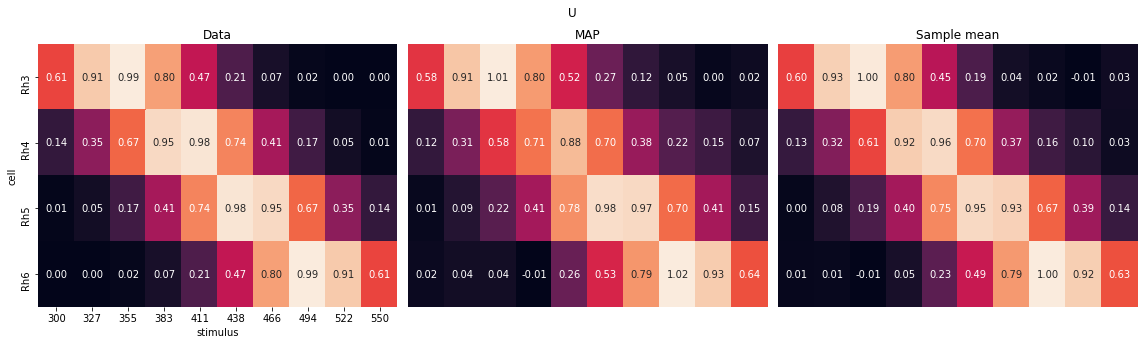

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'U'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Responses

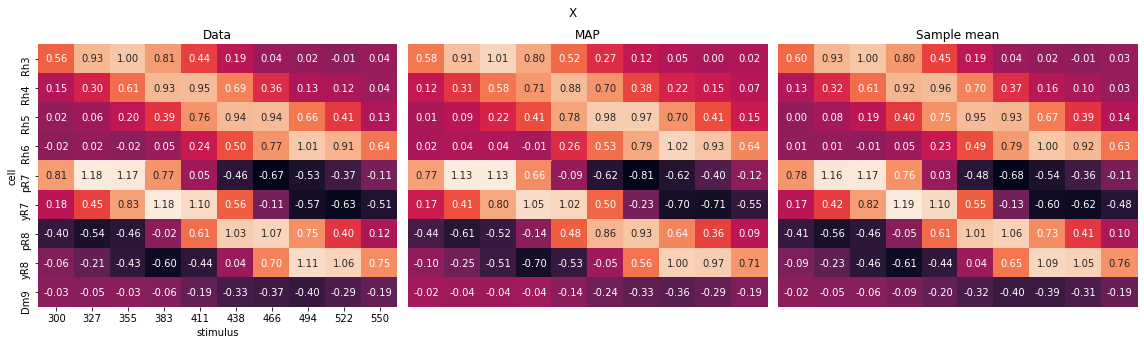

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

titles = ['Data', 'MAP', 'Sample mean']
param = 'X'
for i, dataset in enumerate([data, map_, mean]):
    sns.heatmap(dataset[param], ax=axes[i], annot=True, cbar=False, fmt='.2f')
    axes[i].set_title(titles[i])
    if i != 0:
        axes[i].axis('off')
fig.suptitle(param)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Graphical posterior predictive checking

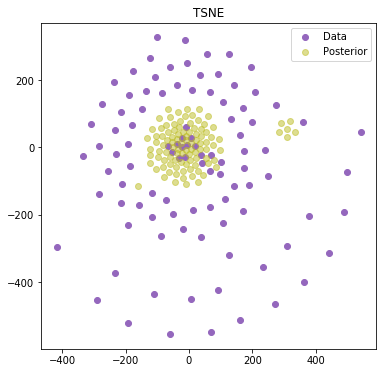

In [24]:
Xflat = np.stack([Xset.iloc[i*9:(i+1)*9].values.ravel() for i in range(len(Xset) // 9)])
samples = ccmf.get_samples()
post_samples = np.array(torch.stack([EX(Wi, Mi, Ui).flatten() for Wi, Mi, Ui in zip(samples['W'], samples['M'], samples['U'])]))
concat = np.concatenate([Xflat, post_samples])
embedding = TSNE(n_components=2, random_state=69)
y = embedding.fit_transform(concat)
labels = np.array([0] * len(Xflat) + [1] * len(post_samples))

plt.figure(figsize=(6, 6))
plt.scatter(*y[labels==0].T, label='Data', c='C4')
plt.scatter(*y[labels==1].T, label='Posterior', c='C8', alpha=.5)
plt.legend()
plt.title('TSNE')
plt.savefig(f'figures/{notebook_name}_tsne.svg', format='svg')